In [5]:
%%capture 
!python3 -m pip install google.cloud
!python3 -m pip install pandas
!python3 -m pip install numpy
!python3 -m pip install pyarrow
!python3 -m pip install statsmodels

In [116]:
import os
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics
magics.context.use_bqstorage_api = True
import pyarrow
from sklearn.linear_model import LogisticRegression
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot as plt
import random
from numpy import cov


In [7]:
#- IMPORT THE LIBRARIES YOU WILL USE
#------------------------------------------
# You only need to import packages one time per notebook session. To keep your
# notebook clean and organized you can handle all imports at the top of your file.
# The following are included for example purposed, feel free to modify or delete 
# anything in this section.

import csv
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics
magics.context.use_bqstorage_api = True
import pyarrow
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import random
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True, linewidth=200, edgeitems=100)

# Pipeline and column transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

# Data transformers
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Data splitter and model evaluator
from sklearn.model_selection import train_test_split, validation_curve, learning_curve, GridSearchCV

# Learning models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, GradientBoostingClassifier, GradientBoostingRegressor
#from xgboost import XGBClassifier, XGBRegressor  # Need to install

# Performance metrics
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [8]:
# CONFIGURE THE BIGQUERY SETTINGS

BIGQUERY_PROJECT = 'ironhacks-covid19-data'
BIGQUERY_KEYPATH = 'service-account.json'

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = BIGQUERY_KEYPATH
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

In [8]:
query = """
SELECT week_number, SUM(device_count_week) as active_device, SUM(completely_home_device_count_per_week) as home_device, SUM(median_home_dwell_time_per_week) as home_time, SUM(median_non_home_dwell_time_per_week) as nonhome_time
FROM ironhacks_covid19_competition.cbg_social_distancing
GROUP BY week_number
ORDER BY week_number
"""

query_job = bigquery_client.query(query)
total = query_job.to_dataframe()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ffb09635990>,
      dtype=object)

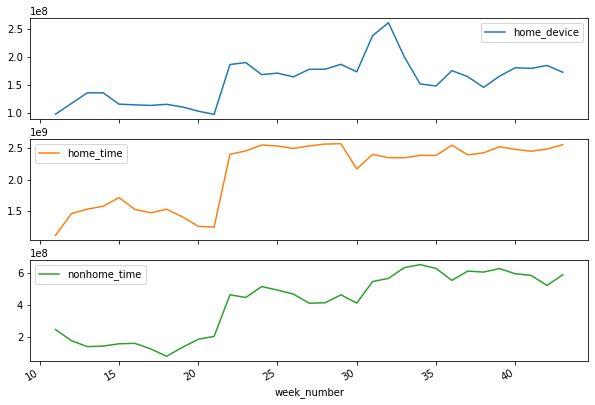

In [21]:
total.plot('week_number', ['home_device', 'home_time','nonhome_time'], subplots=True,figsize=(10,7))

In [9]:
query = """
    SELECT poi_id, top_category, week_number, raw_visit_counts, postal_code, poi_cbg
    FROM ironhacks_covid19_competition.weekly_patterns
    """
query_job = bigquery_client.query(query)
wp = query_job.to_dataframe()

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:441: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


In [153]:
dummy = pd.get_dummies(wp['week_number'])
table = wp.join(dummy)
dummy = pd.get_dummies(wp['top_category'])
table = table.join(dummy)
del table['week_number']
del table['top_category']

In [10]:
query = """
SELECT *
FROM ironhacks_covid19_competition.cbg_social_distancing
"""

query_job = bigquery_client.query(query)
sd = query_job.to_dataframe()

In [11]:
unique = wp['poi_cbg'].unique()
len(unique)

100

In [30]:
filtered = sd.loc[sd['cbg'].isin(unique)]
filtered = filtered.drop_duplicates()

In [152]:
merge = wp.merge(filtered, left_on=['poi_cbg','week_number'], right_on=['cbg','week_number'])
# merge

In [88]:
# merge.to_csv('merge.csv',index=False)

In [86]:
pivot = pd.pivot_table(merge, values='raw_visit_counts', index=['poi_id'],columns=['week_number'], aggfunc='sum')
lis = list(pivot)
lis = [str(ele)+"_week" for ele in lis]
pivot.columns = lis

In [151]:
# pivot.info()

In [51]:
pivot2 = pd.pivot_table(merge, values='device_count_week', index=['poi_id'],columns=['week_number'])
lis = list(pivot2)
lis = [str(ele)+"_device" for ele in lis]
pivot2.columns = lis

In [52]:
pivot3 = pd.pivot_table(merge, values='completely_home_device_count_per_week', index=['poi_id'],columns=['week_number'])
lis = list(pivot3)
lis = [str(ele)+"_complete_home" for ele in lis]
pivot3.columns = lis

In [53]:
pivot4 = pd.pivot_table(merge, values='median_home_dwell_time_per_week', index=['poi_id'],columns=['week_number'])
lis = list(pivot4)
lis = [str(ele)+"_home_time" for ele in lis]
pivot4.columns = lis

In [54]:
pivot5 = pd.pivot_table(merge, values='median_non_home_dwell_time_per_week', index=['poi_id'],columns=['week_number'])
lis = list(pivot5)
lis = [str(ele)+"_non_home" for ele in lis]
pivot5.columns = lis

In [142]:
df = pd.concat([pivot, pivot2, pivot3, pivot4, pivot5], axis=1)

In [150]:
df_t = df.T
df = df_t.fillna(method='bfill').T
# df

In [148]:
X = df.drop(['43_week','43_device', '43_non_home', '43_home_time','42_week','42_device', '42_non_home', '42_home_time'], axis=1)
y = df['42_week']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [149]:
ridge_model = Ridge(alpha = 0.1)
ridge_model.fit(X_train, y_train)
print('Ridge Training score:', ridge_model.score(X_train,y_train))
print('Ridge Test score:    ', ridge_model.score(X_test,y_test),'\n')

lasso_model = Lasso(alpha = 0.1)
lasso_model.fit(X_train, y_train)
print('Lasso Training score:', lasso_model.score(X_train,y_train))
print('Lasso Test score:    ', lasso_model.score(X_test,y_test),'\n')

decision_tree_model = DecisionTreeRegressor(random_state=0)
decision_tree_model.fit(X_train, y_train)
print('Decision Tree Training score:', decision_tree_model.score(X_train,y_train))
print('Decision Tree Test score:    ', decision_tree_model.score(X_test,y_test),'\n')

random_forest_model = RandomForestRegressor(random_state=0)
random_forest_model.fit(X_train, y_train)
print('Random Forest Training score:', random_forest_model.score(X_train,y_train))
print('Random Forest Test score:    ', random_forest_model.score(X_test,y_test),'\n')

gradient_boosting_model = GradientBoostingRegressor(random_state=0)
gradient_boosting_model.fit(X_train, y_train)
print('Gradient Boosting Training score:', gradient_boosting_model.score(X_train,y_train))
print('Gradient Bosting Test score:    ', gradient_boosting_model.score(X_test,y_test),'\n')

Ridge Training score: 0.9811072963592757
Ridge Test score:     0.9670557609059424 



/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 548612.3248866631, tolerance: 5722.401607606973
  positive)


Lasso Training score: 0.9807375196555957
Lasso Test score:     0.9696578178364393 

Decision Tree Training score: 1.0
Decision Tree Test score:     0.9161639332609294 

Random Forest Training score: 0.9861944318579491
Random Forest Test score:     0.9625190725911936 

Gradient Boosting Training score: 0.9970099947081257
Gradient Bosting Test score:     0.958744554182225 



In [98]:
scores = cross_val_score(estimator=random_forest_model, X=X, y=y, cv=10)
print(scores)

In [106]:
raw_visit_counts = random_forest_model.predict(X)
d = pd.DataFrame(columns = ['poi_id', 'raw_visit_counts'])
d['poi_id'] = X.index
d['raw_visit_counts'] = raw_visit_counts
d

array([[1.        , 0.99041405],
       [0.99041405, 1.        ]])

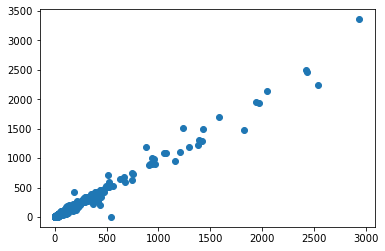

In [122]:
plt.scatter(raw_visit_counts, y)
# raw_visit_counts.corrcoef(y)
np.corrcoef(raw_visit_counts, y)

In [108]:
d.to_csv('random.csv',index=False)